## Packages

In [1]:
import os
import pathlib
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from IPython import display

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models

2024-01-23 08:15:10.943484: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-23 08:15:11.273312: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-23 08:15:11.273519: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-23 08:15:11.314061: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-23 08:15:11.408631: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-23 08:15:11.410818: I tensorflow/core/platform/cpu_feature_guard.cc:1

### Set the seed value for experiment reproducibility.

In [2]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

## Load in the file path

In [4]:
DATASET_PATH = 'dataset/'
data_dir = pathlib.Path(DATASET_PATH)

The dataset's audio clips are stored in eight folders corresponding to each speech command: 
- 'right'
- 'backward'
- 'no'
- 'forward'
- 'left'
- 'stop'

In [5]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
print('Commands:', commands)

Commands: ['right' 'backward' 'no' 'forward' 'left' 'stop']


### Split into Train and validation

In [6]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 6000 files belonging to 6 classes.
Using 4800 files for training.
Using 1200 files for validation.

label names: ['backward' 'forward' 'left' 'no' 'right' 'stop']


The dataset now contains batches of audio clips and integer labels. The audio clips have a shape of `(batch, samples, channels)`.

In [7]:
train_ds.element_spec

(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [8]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

In [9]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [10]:
for example_audio, example_labels in train_ds.take(1):
  print(example_audio.shape)
  print(example_labels.shape)

(64, 16000)
(64,)


### Plot a few audio waveforms:

In [11]:
label_names[[1,2,3,0,4,5]]

array(['forward', 'left', 'no', 'backward', 'right', 'stop'], dtype='<U8')

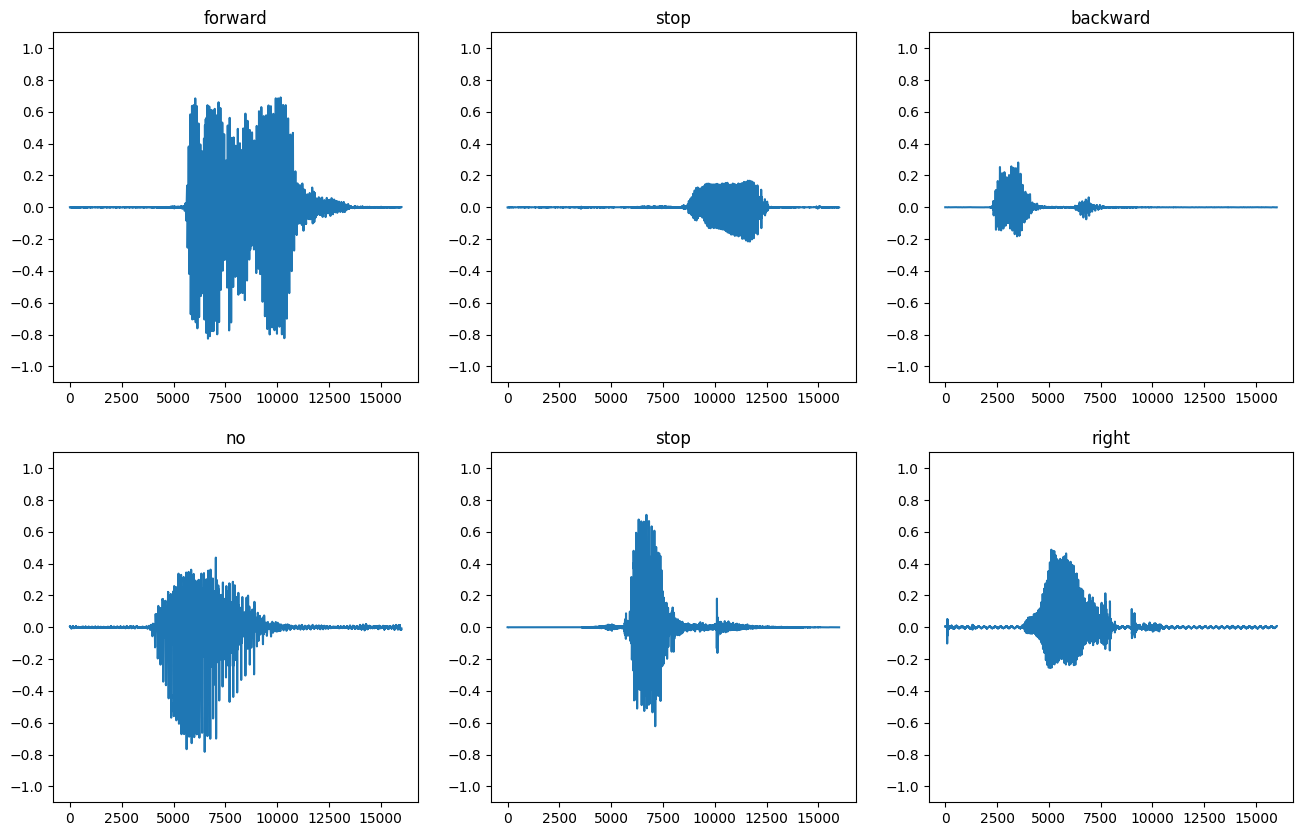

In [12]:
plt.figure(figsize=(16, 10))
rows = 2
cols = 3
n = rows * cols
for i in range(n):
  plt.subplot(rows, cols, i+1)
  audio_signal = example_audio[i]
  plt.plot(audio_signal)
  plt.title(label_names[example_labels[i]])
  plt.yticks(np.arange(-1.2, 1.2, 0.2))
  plt.ylim([-1.1, 1.1])

In [13]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

### The shapes of a tensorized waveform and the corresponding spectrogram, and play the original audio:

In [14]:
for i in range(3):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))

Label: forward
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: stop
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: backward
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


### Function for displaying a spectrogram:

In [15]:
# Convert the frequencies to log scale and transpose, so that the time is
# represented on the x-axis (columns).
# Add an epsilon to avoid taking a log of zero.

def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
      
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

### Plot of waveform over time and the corresponding spectrogram (frequencies over time):

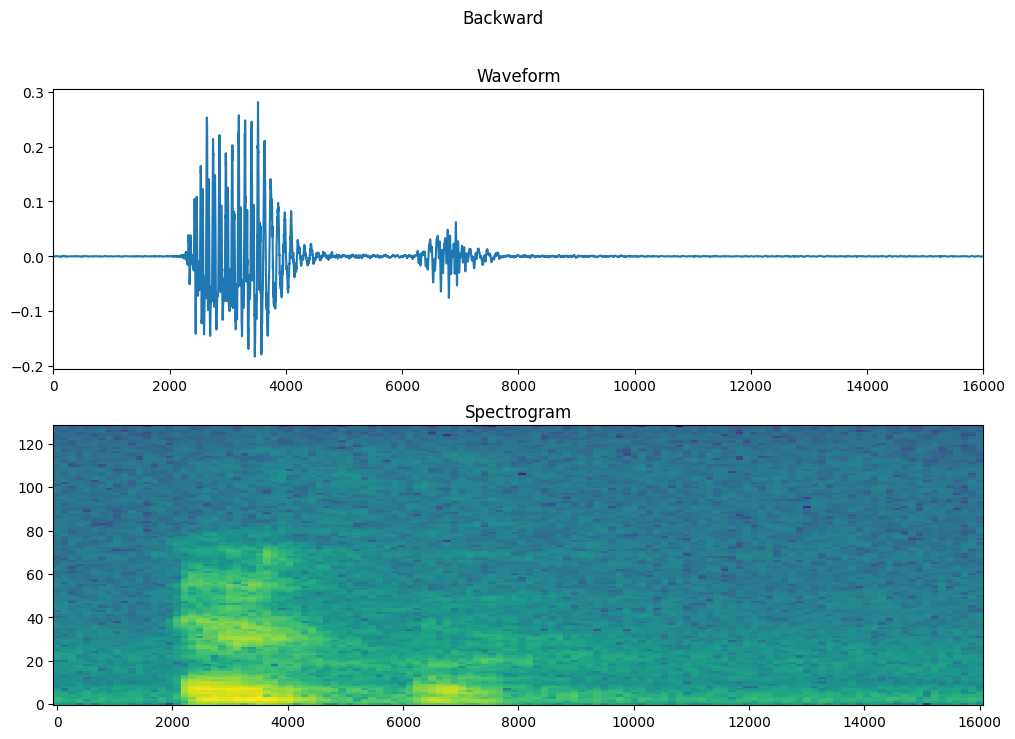

In [16]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

## Create spectrogram datasets from the audio datasets:

In [17]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [18]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

Examine the spectrograms for different examples of the dataset:

In [19]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

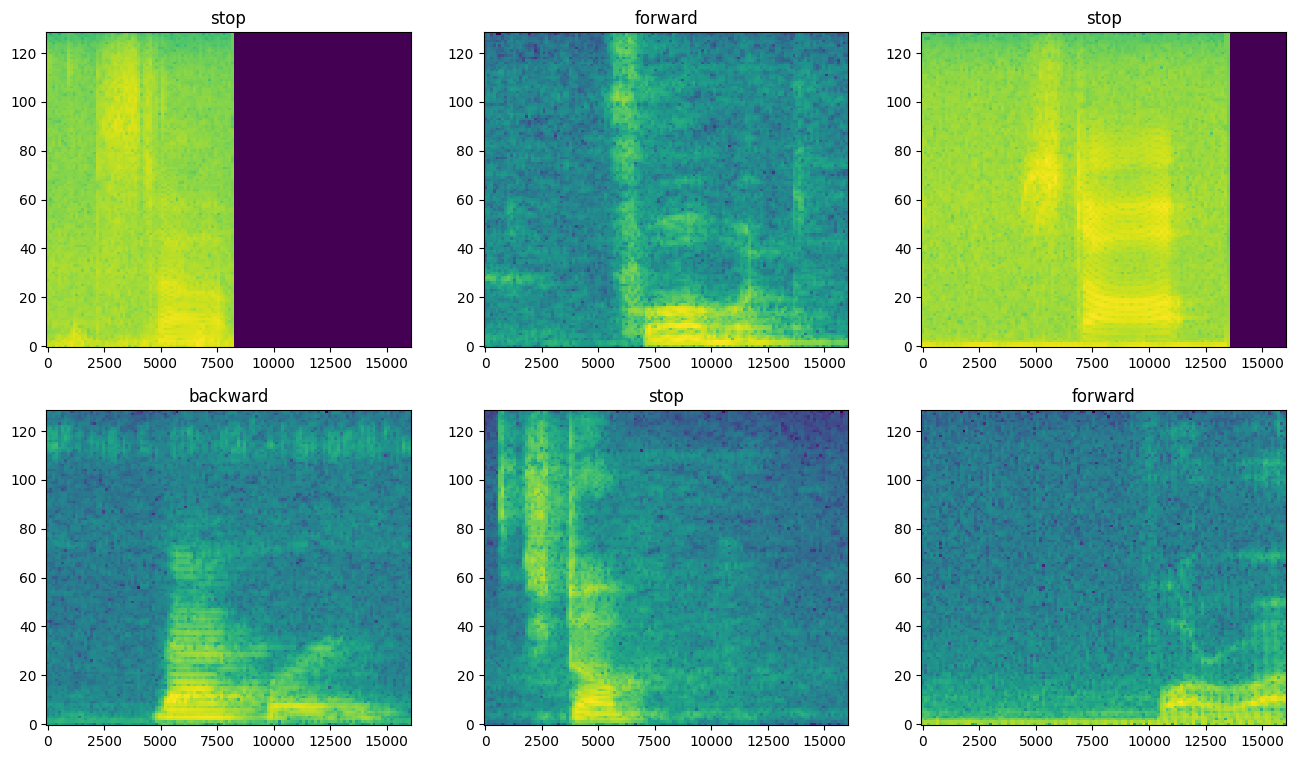

In [20]:
rows = 2
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

### `Dataset.cache` and `Dataset.prefetch` operations to reduce read latency while training the model:

In [21]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

## Model 1

In [22]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)
norm_layer = layers.Normalization()
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (124, 129, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizati  (None, 32, 32, 1)         3         
 on)                                                             
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           

### Keras model with the Adam optimizer and the cross-entropy loss:

In [23]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

### Train the model

In [24]:
EPOCHS = 10
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10
75/75 [==============================] - 17s 199ms/step - loss: 1.4086 - accuracy: 0.4762 - val_loss: 0.8556 - val_accuracy: 0.7431
Epoch 2/10
75/75 [==============================] - 14s 188ms/step - loss: 0.8280 - accuracy: 0.7223 - val_loss: 0.5939 - val_accuracy: 0.8073
Epoch 3/10
75/75 [==============================] - 13s 174ms/step - loss: 0.5670 - accuracy: 0.8194 - val_loss: 0.3997 - val_accuracy: 0.8958
Epoch 4/10
75/75 [==============================] - 14s 184ms/step - loss: 0.4234 - accuracy: 0.8590 - val_loss: 0.3101 - val_accuracy: 0.9149
Epoch 5/10
75/75 [==============================] - 13s 177ms/step - loss: 0.3573 - accuracy: 0.8881 - val_loss: 0.2887 - val_accuracy: 0.9132
Epoch 6/10
75/75 [==============================] - 12s 162ms/step - loss: 0.2973 - accuracy: 0.9062 - val_loss: 0.2955 - val_accuracy: 0.9149
Epoch 7/10
75/75 [==============================] - 12s 158ms/step - loss: 0.2618 - accuracy: 0.9156 - val_loss: 0.2368 - val_accuracy: 0.9375

### Plot the training and validation loss curves to check how your model has improved during training:

Text(0, 0.5, 'Accuracy [%]')

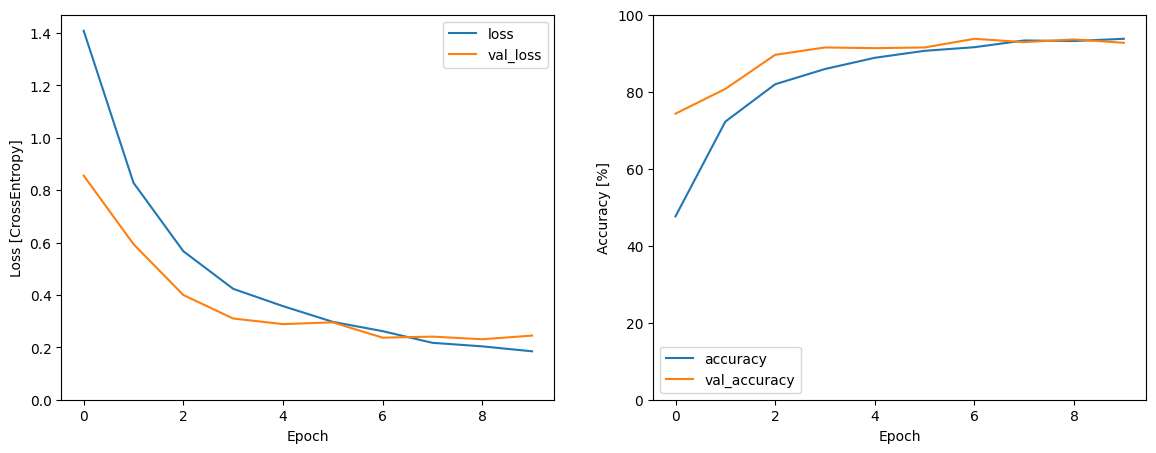

In [25]:
metrics = history.history
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

### Evaluate the model performance

Run the model on the test set and check the model's performance:

In [26]:
model.evaluate(test_spectrogram_ds, return_dict=True)

10/10 [==============================] - 1s 68ms/step - loss: 0.2788 - accuracy: 0.9135


{'loss': 0.27879956364631653, 'accuracy': 0.9134615659713745}

### Display a confusion matrix

In [27]:
y_pred = model.predict(test_spectrogram_ds)

10/10 [==============================] - 1s 42ms/step


In [28]:
y_pred = tf.argmax(y_pred, axis=1)

In [29]:
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

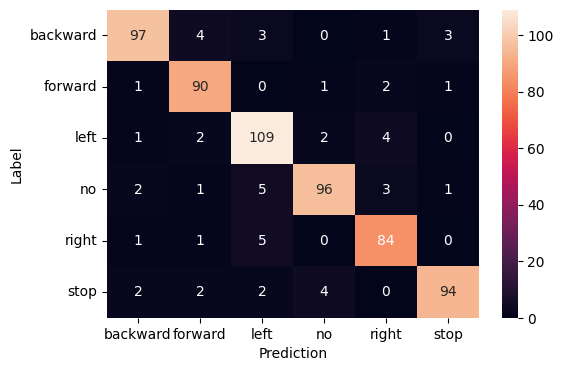

In [30]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

### Inference on an audio file

In [43]:
x = data_dir/'no/01bb6a2a_nohash_0.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]

x_labels = ['backward','forward', 'left', 'no', 'right', 'stop']
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title('No')
plt.show()

display.display(display.Audio(waveform, rate=16000))

NameError: name 'prediction' is not defined

### Export the model with preprocessing

In [ ]:
class ExportModel(tf.Module):
  def __init__(self, model):
    self.model = model

    # Accept either a string-filename or a batch of waveforms.
    # YOu could add additional signatures for a single wave, or a ragged-batch.
    self.__call__.get_concrete_function(
        x=tf.TensorSpec(shape=(), dtype=tf.string))
    self.__call__.get_concrete_function(
       x=tf.TensorSpec(shape=[None, 16000], dtype=tf.float32))


  @tf.function
  def __call__(self, x):
    # If they pass a string, load the file and decode it.
    if x.dtype == tf.string:
      x = tf.io.read_file(x)
      x, _ = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
      x = tf.squeeze(x, axis=-1)
      x = x[tf.newaxis, :]

    x = get_spectrogram(x)
    result = self.model(x, training=False)

    class_ids = tf.argmax(result, axis=-1)
    class_names = tf.gather(label_names, class_ids)
    return {'predictions':result,
            'class_ids': class_ids,
            'class_names': class_names}

## Model 2

In [31]:
model2 = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Resizing(32, 32),
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])


In [32]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_1 (Resizing)       (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizati  (None, 32, 32, 1)         3         
 on)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 30, 30, 32)        320       
                                                                 
 batch_normalization (Batch  (None, 30, 30, 32)        128       
 Normalization)                                                  
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 15, 15, 32)        0         
 g2D)                                                            
                                                      

In [33]:
model2.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

timizer=tf.keras.optimizers.Adam(),
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),


In [34]:
EPOCHS = 10
history = model2.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10
75/75 [==============================] - 11s 92ms/step - loss: 1.8677 - accuracy: 0.3981 - val_loss: 1.6370 - val_accuracy: 0.3038
Epoch 2/10
75/75 [==============================] - 6s 82ms/step - loss: 1.1117 - accuracy: 0.5773 - val_loss: 1.5492 - val_accuracy: 0.3628
Epoch 3/10
75/75 [==============================] - 6s 85ms/step - loss: 0.8744 - accuracy: 0.6873 - val_loss: 1.5623 - val_accuracy: 0.3663
Epoch 4/10
75/75 [==============================] - 6s 78ms/step - loss: 0.7049 - accuracy: 0.7519 - val_loss: 1.4134 - val_accuracy: 0.4479
Epoch 5/10
75/75 [==============================] - 6s 78ms/step - loss: 0.5923 - accuracy: 0.7971 - val_loss: 1.0857 - val_accuracy: 0.6042
Epoch 6/10
75/75 [==============================] - 6s 81ms/step - loss: 0.4836 - accuracy: 0.8315 - val_loss: 0.8223 - val_accuracy: 0.6979
Epoch 7/10
75/75 [==============================] - 6s 82ms/step - loss: 0.4335 - accuracy: 0.8512 - val_loss: 0.8117 - val_accuracy: 0.7378
Epoch 8/10
7

Text(0, 0.5, 'Accuracy [%]')

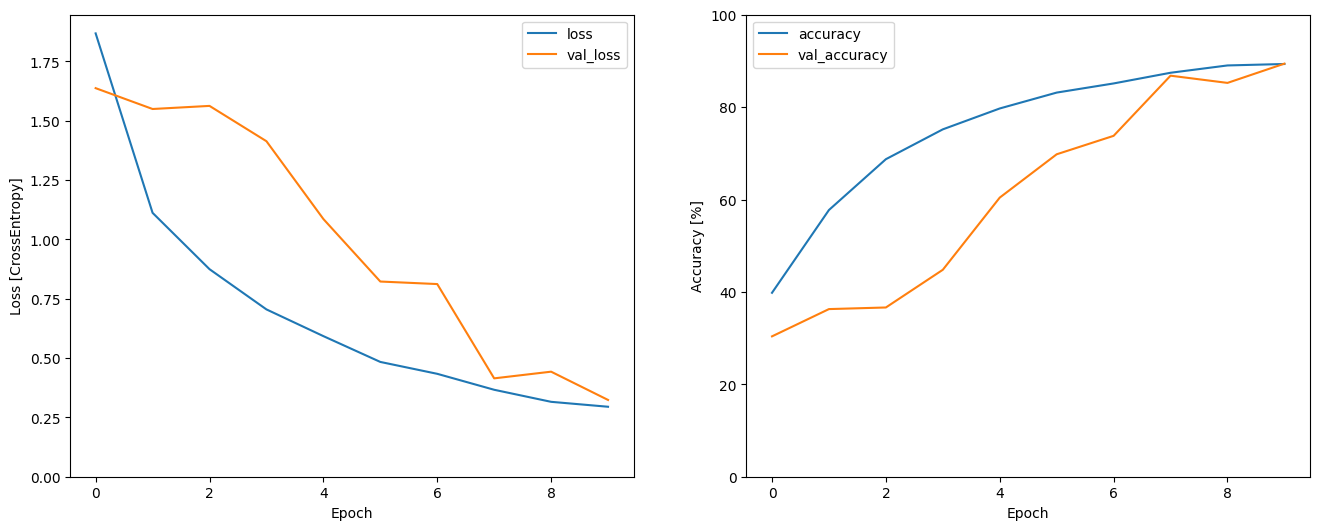

In [35]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

### Evaluate the model

In [36]:
model2.evaluate(test_spectrogram_ds, return_dict=True)

10/10 [==============================] - 0s 23ms/step - loss: 0.3404 - accuracy: 0.8830


{'loss': 0.3404487073421478, 'accuracy': 0.8830128312110901}

In [37]:
y_pred = model2.predict(test_spectrogram_ds)
y_pred = tf.argmax(y_pred, axis=1)

10/10 [==============================] - 0s 22ms/step


In [38]:
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

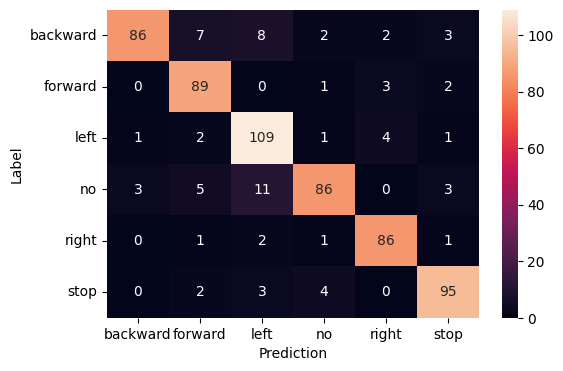

In [39]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## Model 3

In [54]:
model3 = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Conv2D(32, 3, activation='relu', dilation_rate=(2, 2)),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu', dilation_rate=(2, 2)),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu', dilation_rate=(2, 2)),
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])


In [55]:
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 120, 125, 32)      320       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 60, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 56, 58, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 28, 29, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 24, 25, 128)       73856     
                                                                 
 global_average_pooling2d (  (None, 128)              

In [56]:
model3.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [57]:
EPOCHS = 10
history = model3.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10
75/75 [==============================] - 115s 1s/step - loss: 1.7094 - accuracy: 0.2617 - val_loss: 1.6057 - val_accuracy: 0.3958
Epoch 2/10
75/75 [==============================] - 110s 1s/step - loss: 1.5305 - accuracy: 0.3779 - val_loss: 1.3741 - val_accuracy: 0.4878
Epoch 3/10
75/75 [==============================] - 111s 1s/step - loss: 1.3508 - accuracy: 0.4856 - val_loss: 1.1879 - val_accuracy: 0.5781
Epoch 4/10
75/75 [==============================] - 108s 1s/step - loss: 1.1181 - accuracy: 0.5877 - val_loss: 0.8804 - val_accuracy: 0.6979
Epoch 5/10
75/75 [==============================] - 124s 2s/step - loss: 0.9181 - accuracy: 0.6758 - val_loss: 0.7331 - val_accuracy: 0.7882
Epoch 6/10
75/75 [==============================] - 127s 2s/step - loss: 0.7548 - accuracy: 0.7519 - val_loss: 0.5955 - val_accuracy: 0.8316
Epoch 7/10
75/75 [==============================] - 127s 2s/step - loss: 0.6536 - accuracy: 0.7856 - val_loss: 0.4934 - val_accuracy: 0.8733
Epoch 8/10
75

Text(0, 0.5, 'Accuracy [%]')

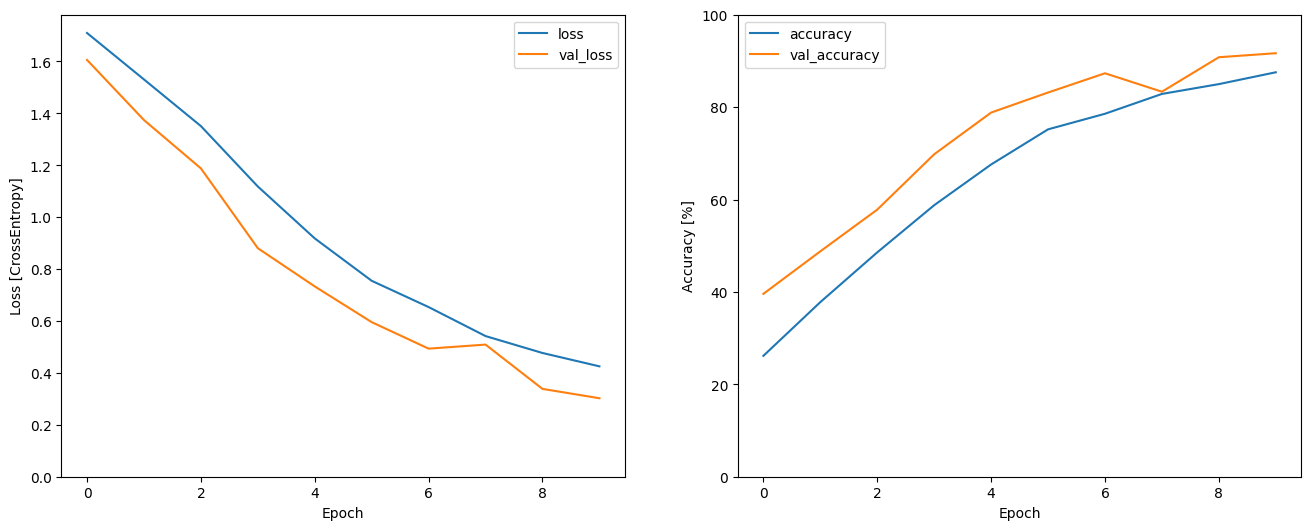

In [58]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

### Evaluate the model

In [59]:
model3.evaluate(test_spectrogram_ds, return_dict=True)

10/10 [==============================] - 6s 606ms/step - loss: 0.3511 - accuracy: 0.9054


{'loss': 0.3510500490665436, 'accuracy': 0.9054487347602844}

In [60]:
y_pred = model3.predict(test_spectrogram_ds)
y_pred = tf.argmax(y_pred, axis=1)

10/10 [==============================] - 6s 574ms/step


In [61]:
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

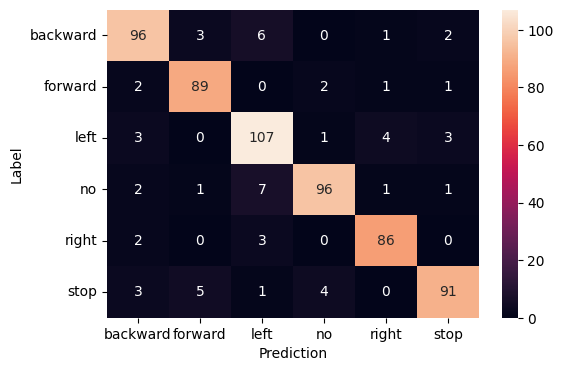

In [62]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## Model 4

In [73]:

train_spectrogram_ds = train_spectrogram_ds.map(lambda x, y: (tf.image.grayscale_to_rgb(x), y))
val_spectrogram_ds = val_spectrogram_ds.map(lambda x, y: (tf.image.grayscale_to_rgb(x), y))

In [74]:
input_shape = (124, 129, 3) 
base_model = tf.keras.applications.MobileNetV2(
    input_shape=input_shape, include_top=False, weights='imagenet')
base_model.trainable = False

model4 = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])


In [75]:
model4.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 4, 5, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_5  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_14 (Dense)            (None, 128)               163968    
                                                                 
 dropout_9 (Dropout)         (None, 128)               0         
                                                                 
 dense_15 (Dense)            (None, 6)                 774       
                                                                 
Total params: 2422726 (9.24 MB)
Trainable params: 1647

In [76]:
model4.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [77]:
EPOCHS = 10
history = model4.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10
75/75 [==============================] - 55s 624ms/step - loss: 1.4772 - accuracy: 0.4321 - val_loss: 0.9941 - val_accuracy: 0.6701
Epoch 2/10
75/75 [==============================] - 48s 635ms/step - loss: 1.0533 - accuracy: 0.6179 - val_loss: 0.7865 - val_accuracy: 0.7413
Epoch 3/10
75/75 [==============================] - 45s 597ms/step - loss: 0.9142 - accuracy: 0.6660 - val_loss: 0.7179 - val_accuracy: 0.7344
Epoch 4/10
75/75 [==============================] - 46s 613ms/step - loss: 0.8194 - accuracy: 0.7054 - val_loss: 0.6428 - val_accuracy: 0.7847
Epoch 5/10
75/75 [==============================] - 45s 603ms/step - loss: 0.7402 - accuracy: 0.7340 - val_loss: 0.5935 - val_accuracy: 0.8090
Epoch 6/10
75/75 [==============================] - 44s 583ms/step - loss: 0.6853 - accuracy: 0.7523 - val_loss: 0.5738 - val_accuracy: 0.7969
Epoch 7/10
75/75 [==============================] - 43s 572ms/step - loss: 0.6485 - accuracy: 0.7631 - val_loss: 0.5482 - val_accuracy: 0.8090

Text(0, 0.5, 'Accuracy [%]')

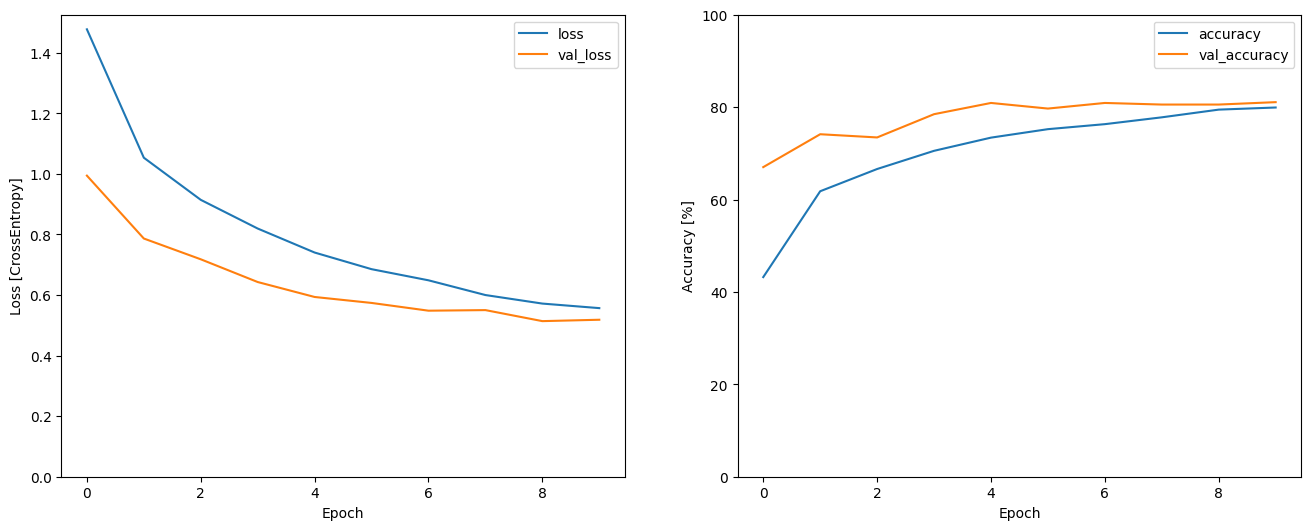

In [80]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

### Evaluate the model

In [82]:
model4.evaluate(val_spectrogram_ds, return_dict=True)


9/9 [==============================] - 5s 547ms/step - loss: 0.5183 - accuracy: 0.8108


{'loss': 0.5182991027832031, 'accuracy': 0.8107638955116272}

In [85]:
y_pred = model4.predict(val_spectrogram_ds)
y_pred = tf.argmax(y_pred, axis=1)

9/9 [==============================] - 7s 535ms/step


In [86]:
y_true = tf.concat(list(val_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

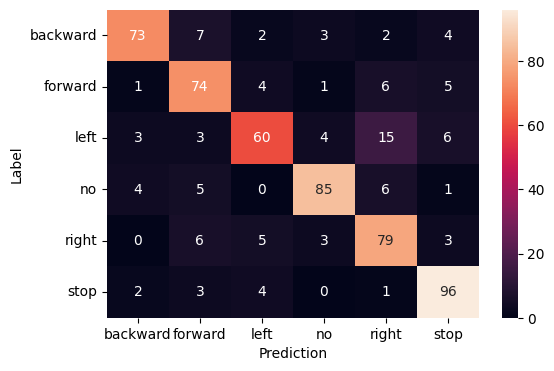

In [87]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()